<div class="alert alert-success" style = "border-radius: 20px;text-align: center;" role="alert">
    Don't forget to upvote if you liked the notebook
</div>

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

D0725 18:10:15.090602505      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0725 18:10:15.090628416      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0725 18:10:15.090632238      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0725 18:10:15.090635092      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0725 18:10:15.090637706      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0725 18:10:15.090641468      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0725 18:10:15.090644287      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0725 18:10:15.

# Preparing TPU

In [2]:
AUTO = tf.data.experimental.AUTOTUNE

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/

# Loading Data

In [3]:
from tensorflow.keras.datasets import cifar100

(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='coarse')

169001437/169001437 [==============================] - 2s 0us/step


In [4]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


# Resizing images

In [5]:
import cv2
X_train = np.array([cv2.resize(img, (224, 224)) for img in X_train])

In [6]:
X_test = np.array([cv2.resize(img, (224, 224)) for img in X_test])

# Encoding labels

In [7]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y_train=enc.fit_transform(y_train).toarray().astype(int)
y_test=enc.transform(y_test).toarray().astype(int)


print(y_train.shape)
print(y_train[0])

(50000, 20)
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


# Preparing mobileNet_V2's Preprocessing

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Transfer Learning from MobileNet_V2

In [9]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
MobileNet = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
MobileNet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

# Using MobileNet_V2 in my architecture

I will build two architectures to see the improvement that I do on the first one

In [ ]:
def transfer_from_MN(image_shape=IMG_SIZE):

    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(inputs)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)

    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(units=20, activation='softmax')(x)

    ### END CODE HERE

    model = tf.keras.Model(inputs, outputs)

    return model

In [12]:
def transfer_from_MN_2(image_shape=IMG_SIZE):

    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(inputs)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)

    x = tfl.Dense(units=100)(x)
    x = tfl.LeakyReLU()(x)
    x = tfl.Dropout(0.2)(x)
    x = tfl.Dense(units=100)(x)
    x = tfl.LeakyReLU()(x)
    x = tfl.Dropout(0.2)(x)
    x = tfl.Dense(units=100)(x)
    x = tfl.LeakyReLU()(x)
    x = tfl.Dropout(0.2)(x)
    x = tfl.Dense(units=100)(x)
    x = tfl.LeakyReLU()(x)
    x = tfl.Dropout(0.2)(x)
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(units=20, activation='softmax')(x)

    ### END CODE HERE

    model = tf.keras.Model(inputs, outputs)

    return model

# Training and evaluating the model

In [13]:
# instantiating the model in the strategy scope creates the model on the TPU
with strategy.scope():
    CIFAR_Recognizer_1 = transfer_from_MN(IMG_SIZE)
    CIFAR_Recognizer_1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    CIFAR_Recognizer_2 = transfer_from_MN_2(IMG_SIZE)
    CIFAR_Recognizer_2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16 * strategy.num_replicas_in_sync)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16 * strategy.num_replicas_in_sync)
initial_epochs = 50

In [15]:
history1 = CIFAR_Recognizer_1.fit(train_dataset, validation_data=test_dataset, batch_size=16 * strategy.num_replicas_in_sync,epochs=initial_epochs,shuffle=True)

Epoch 1/50


2023-07-25 18:11:52.402573: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-25 18:11:52.705839: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


391/391 [==============================] - ETA: 0s - loss: 1.3939 - accuracy: 0.5728

2023-07-25 18:12:23.814406: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-25 18:12:24.091985: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


391/391 [==============================] - 52s 99ms/step - loss: 1.3939 - accuracy: 0.5728 - val_loss: 0.9930 - val_accuracy: 0.6818
Epoch 2/50
391/391 [==============================] - 16s 41ms/step - loss: 1.0152 - accuracy: 0.6785 - val_loss: 0.9193 - val_accuracy: 0.7036
Epoch 3/50
391/391 [==============================] - 16s 41ms/step - loss: 0.9473 - accuracy: 0.6988 - val_loss: 0.8990 - val_accuracy: 0.7101
Epoch 4/50
391/391 [==============================] - 16s 42ms/step - loss: 0.9111 - accuracy: 0.7082 - val_loss: 0.8824 - val_accuracy: 0.7135
Epoch 5/50
391/391 [==============================] - 16s 40ms/step - loss: 0.8896 - accuracy: 0.7153 - val_loss: 0.8726 - val_accuracy: 0.7199
Epoch 6/50
391/391 [==============================] - 16s 42ms/step - loss: 0.8734 - accuracy: 0.7177 - val_loss: 0.8655 - val_accuracy: 0.7228
Epoch 7/50
391/391 [==============================] - 16s 40ms/step - loss: 0.8651 - accuracy: 0.7243 - val_loss: 0.8621 - val_accuracy: 0.7242
Epo

In [16]:
history2 = CIFAR_Recognizer_2.fit(train_dataset, validation_data=test_dataset, batch_size=16 * strategy.num_replicas_in_sync,epochs=initial_epochs,shuffle=True)

Epoch 1/50


2023-07-25 18:30:50.901887: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-25 18:30:51.215764: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


391/391 [==============================] - ETA: 0s - loss: 1.6391 - accuracy: 0.4816

2023-07-25 18:31:22.999114: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-25 18:31:23.294522: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


391/391 [==============================] - 54s 99ms/step - loss: 1.6391 - accuracy: 0.4816 - val_loss: 1.0872 - val_accuracy: 0.6601
Epoch 2/50
391/391 [==============================] - 16s 42ms/step - loss: 1.2277 - accuracy: 0.6143 - val_loss: 0.9873 - val_accuracy: 0.6879
Epoch 3/50
391/391 [==============================] - 16s 40ms/step - loss: 1.1341 - accuracy: 0.6426 - val_loss: 0.9451 - val_accuracy: 0.7007
Epoch 4/50
391/391 [==============================] - 16s 42ms/step - loss: 1.0874 - accuracy: 0.6581 - val_loss: 0.9145 - val_accuracy: 0.7080
Epoch 5/50
391/391 [==============================] - 17s 42ms/step - loss: 1.0460 - accuracy: 0.6734 - val_loss: 0.8849 - val_accuracy: 0.7209
Epoch 6/50
391/391 [==============================] - 16s 42ms/step - loss: 1.0213 - accuracy: 0.6790 - val_loss: 0.8834 - val_accuracy: 0.7189
Epoch 7/50
391/391 [==============================] - 17s 43ms/step - loss: 0.9993 - accuracy: 0.6842 - val_loss: 0.8742 - val_accuracy: 0.7218
Epo

# Models' performance¶

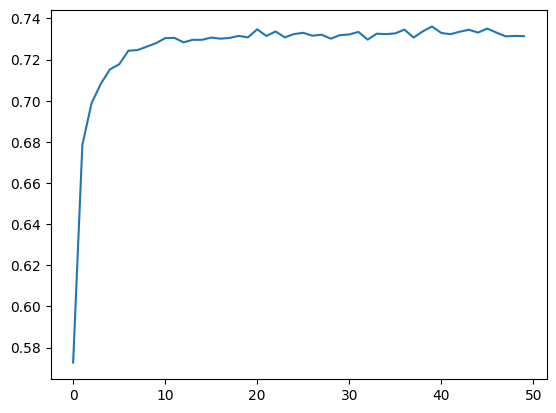

In [17]:
plt.plot(history1.history["accuracy"])

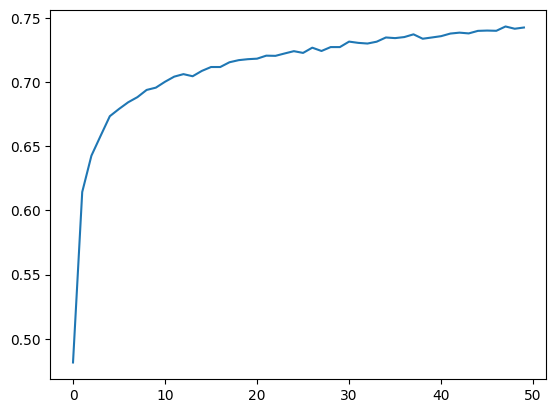

In [18]:
plt.plot(history2.history["accuracy"])

# Saving the model¶

In [19]:
tf.keras.models.save_model(CIFAR_Recognizer_2, '/kaggle/working/model.h5')

# Downloading the model

In [20]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'model.zip'):
    """
    zip all the files in a directory

    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory

    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'

    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [21]:
zip_dir()

/kaggle/working/model.zip